# <font style="color:rgb(50,120,229)">Application: Sunglass Filter </font>

In this section, we will create a simple and fun application using some of the topics we have learned so far.

We will put a sunglass on the face of Elon Musk and make him look cool ( as if he doesn't look so already! ).

![](https://www.dropbox.com/s/4w87z3mkr75lpa0/musk_with_sunglass.png?dl=1)

In [1]:
# Import libraries
import cv2
import numpy as np
# from dataPath import DATA_PATH
import os
import matplotlib.pyplot as plt
%matplotlib inline

DATA_PATH = '.'

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

## <font style="color:rgb(50,120,229)">Load the Face and sunglass Images </font>
First of all, we will need the two images:
1. Image of Elon Musk we have been using throughout
1. A png image of a sunglass with an alpha channel

Let us load the images and have a look at them.

Sunglass Dimension = (273, 627, 4)
Sunglass Dimension = (100, 300, 4)


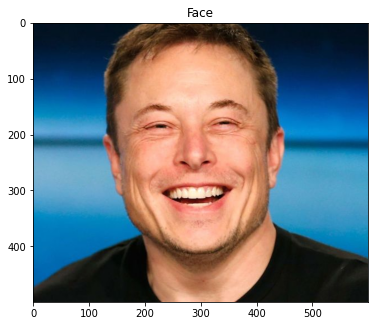

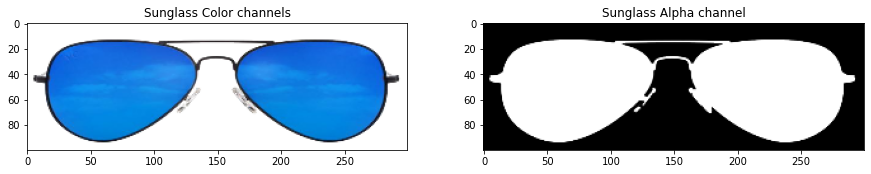

In [16]:
# Load the Face Image
faceImagePath = os.path.join(DATA_PATH,"data/images/musk.jpg")
faceImage = cv2.imread(faceImagePath)

plt.imshow(faceImage[:,:,::-1]);plt.title("Face")

# Load the Sunglass image with Alpha channel
# (http://pluspng.com/sunglass-png-1104.html)
glassimagePath = os.path.join(DATA_PATH, "data/images/sunglass.png")
glassPNG = cv2.imread(glassimagePath, cv2.IMREAD_UNCHANGED)
print("Sunglass Dimension = {}".format(glassPNG.shape))

# Resize the image to fit over the eye region
glassPNG = cv2.resize(glassPNG,(300,100))
print("Sunglass Dimension = {}".format(glassPNG.shape))

# Separate the Color and alpha channels
glassBGR = glassPNG[:,:,0:3]
glassMask1 = glassPNG[:,:,3]

# Display the images for clarity
plt.figure(figsize=[15,15])
plt.subplot(121);plt.imshow(glassBGR[:,:,::-1]);plt.title('Sunglass Color channels');
plt.subplot(122);plt.imshow(glassMask1);plt.title('Sunglass Alpha channel'); # ,cmap='gray'

## <font style="color:rgb(50,120,229)">Find the eye region </font>
From the face image, we can see that the eye region lies approximately from row #150 to row #250 and col #140 to col #440. Thus, this will be region where the sunglass is to be placed.

## <font style="color:rgb(50,120,229)">Using Naive Replace</font>
The easiest way that might have come to your mind would be to just replace the eye region with that of the sunglass. Let us give it a try.

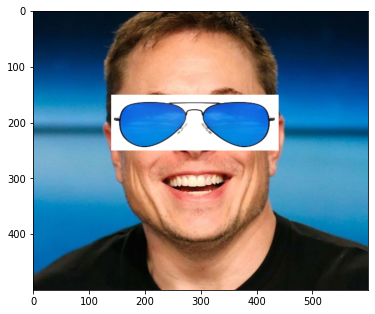

In [17]:
# Make a copy
faceWithGlassesNaive = faceImage.copy()

# Replace the eye region with the sunglass image
faceWithGlassesNaive[150:250,140:440]=glassBGR

plt.imshow(faceWithGlassesNaive[...,::-1])
plt.show()

You can see that the output is not even close. This is because the BGR image is opaque and will either have a black or white rectangle around the sunglass. 

We need to use a mask along with the sunglass image in order to get the desired output. Let us see how it can be done with very simple steps using the tools we have learned till now.

## <font style="color:rgb(50,120,229)">Using Arithmetic Operations and Alpha Mask</font>
In order to put the sunglass on top of the eye region, we need to follow these steps:

1. Create a binary mask with 3-channels using the single channel mask.
1. Extract the eye region from the face image
1. Multiply the Mask with the sunglass to get the masked sunglass
1. Multiply the negative of Mask with the eye region to create a hole in the eye region for the sunglass to be placed.
1. Add the masked sunglass and eye regions to get the combined eye region with the sunglass.
1. Replace the eye region in the original image with that of the output we got in the previous step. This is the final output


(100, 300, 3)
(300, 3)
glassMask [0 0 0] tranparent
glassMask [255 255 255] not tranparent
glassMask [0 0 0] tranparent
glassMask [1 1 1] not tranparent
eyeROI [32 37 46]
eyeROI [ 99 128 209]
maskedEyev1 [0 0 0]
maskedEyev1 [ 99 128 209]
maskedEyev2 [32 37 46]
maskedEyev2 [0 0 0]

maskedGlass [0 0 0]
maskedGlass [227 116  16]


Text(0.5, 1.0, 'Augmented Eye and Sunglass v2')

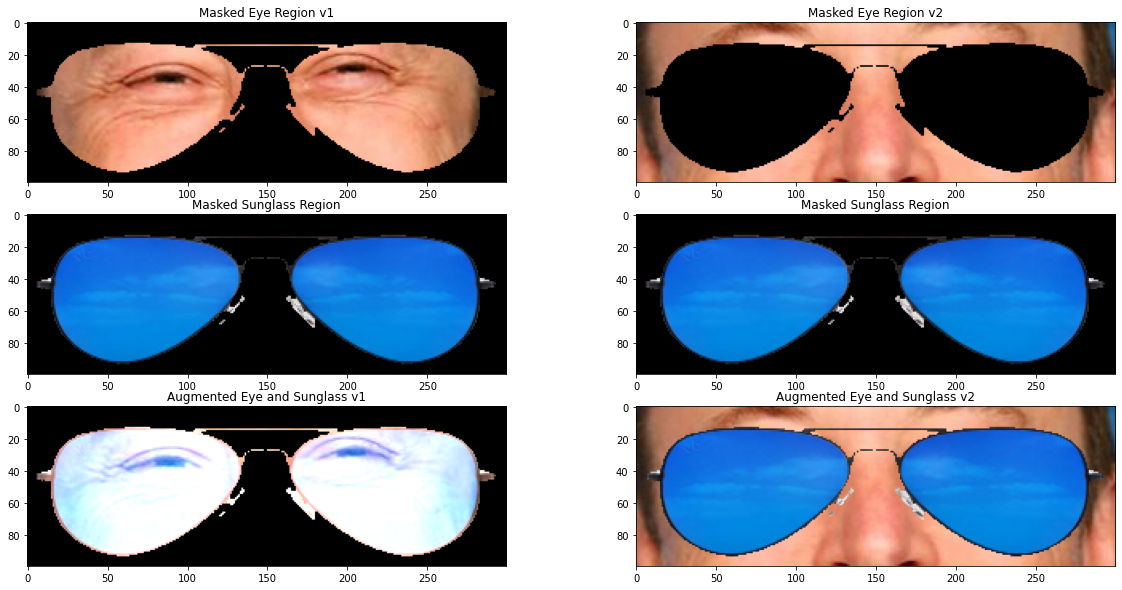

In [63]:
# Make the dimensions of the mask same as the input image.
# Since Face Image is a 3-channel image, we create a 3 channel image for the mask

TRANSPARENCY = 0.1

glassMask = cv2.merge((glassMask1,glassMask1,glassMask1))
print(glassMask.shape)
print(glassMask[0].shape)
print('glassMask', glassMask[0][0], 'tranparent')          # tranparent pixel
print('glassMask', glassMask[40][50], 'not tranparent')    # not transparent pixel

# Make the values [0,1] since we are using arithmetic operations
glassMask = np.uint8(glassMask/255)
print('glassMask', glassMask[0][0], 'tranparent') 
print('glassMask', glassMask[40][50], 'not tranparent') 

# Make a copy
faceWithGlassesArithmetic = faceImage.copy()

# Get the eye region from the face image
eyeROI= faceWithGlassesArithmetic[150:250,140:440]
print('eyeROI', eyeROI[0][0])
print('eyeROI', eyeROI[40][50])

# Use the mask to create the masked eye region
maskedEyev1 = cv2.multiply(eyeROI,(glassMask))
print('maskedEyev1', maskedEyev1[0][0])
print('maskedEyev1', maskedEyev1[40][50])
maskedEyev2 = cv2.multiply(eyeROI, 1 - glassMask) # The values around the glasses become the face and in the glasses area 0!
print('maskedEyev2', maskedEyev2[0][0])
print('maskedEyev2', maskedEyev2[40][50])

# Use the mask to create the masked sunglass region
maskedGlass = cv2.multiply(glassBGR, glassMask)
print()
print('maskedGlass', maskedGlass[0][0])
print('maskedGlass', maskedGlass[40][50])

# Combine the Sunglass in the Eye Region to get the augmented image
eyeRoiFinalv1 = cv2.add(maskedEyev1, maskedGlass)
eyeRoiFinalv2 = cv2.add(maskedEyev2, maskedGlass)

# Display the intermediate results
plt.figure(figsize=[20,10])
plt.subplot(321);plt.imshow(maskedEyev1[...,::-1]);plt.title("Masked Eye Region v1")
plt.subplot(322);plt.imshow(maskedEyev2[...,::-1]);plt.title("Masked Eye Region v2")

plt.subplot(323);plt.imshow(maskedGlass[...,::-1]);plt.title("Masked Sunglass Region")
plt.subplot(324);plt.imshow(maskedGlass[...,::-1]);plt.title("Masked Sunglass Region")

plt.subplot(325);plt.imshow(eyeRoiFinalv1[...,::-1]);plt.title("Augmented Eye and Sunglass v1")
plt.subplot(326);plt.imshow(eyeRoiFinalv2[...,::-1]);plt.title("Augmented Eye and Sunglass v2")

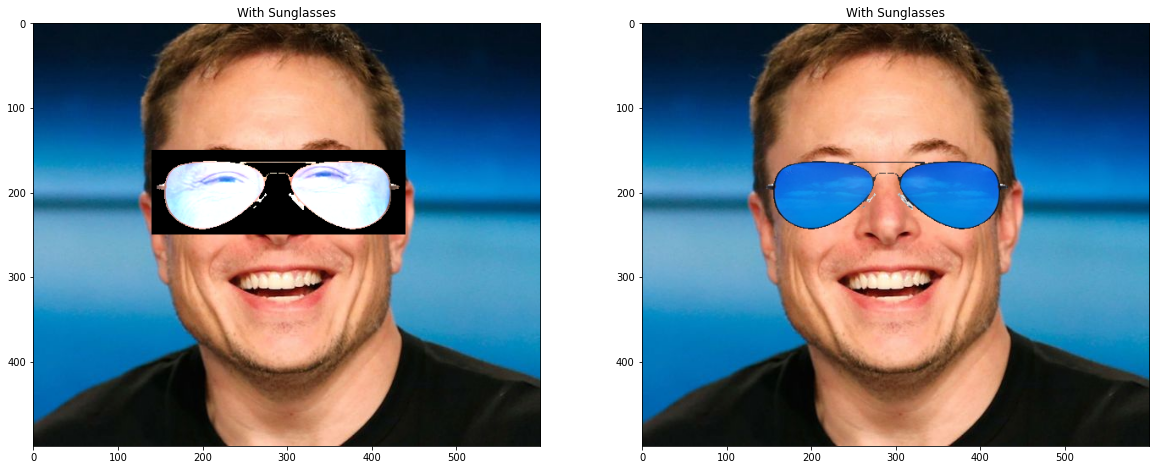

In [41]:
# Replace the eye ROI with the output from the previous section
face1 = faceWithGlassesArithmetic.copy()
face2 = faceWithGlassesArithmetic.copy()

face1[150:250,140:440]=eyeRoiFinalv1
face2[150:250,140:440]=eyeRoiFinalv2

# Display the final result
plt.figure(figsize=[20,20]);
# plt.subplot(121);plt.imshow(faceImage[:,:,::-1]); plt.title("Original Image");
plt.subplot(121);plt.imshow(face1[:,:,::-1]);plt.title("With Sunglasses");
plt.subplot(122);plt.imshow(face2[:,:,::-1]);plt.title("With Sunglasses");

## Transparency

(100, 300, 3)
(300, 3)
glassMask [0 0 0] tranparent
glassMask [255 255 255] not tranparent
glassMask [0. 0. 0.] tranparent
glassMask [0.5 0.5 0.5] not tranparent
eyeROI [32 37 46]
eyeROI [ 99 128 209]
maskedEyev2 [32. 37. 46.]
maskedEyev2 [ 49.5  64.  104.5]
maskedEyev2 [32 37 46]
maskedEyev2 [ 49  64 104]
glassBGR [255 255 255]
glassBGR [227 116  16]
maskedGlass [0 0 0]
maskedGlass [113  58   8]


Text(0.5, 1.0, 'Augmented Eye and Sunglass v2')

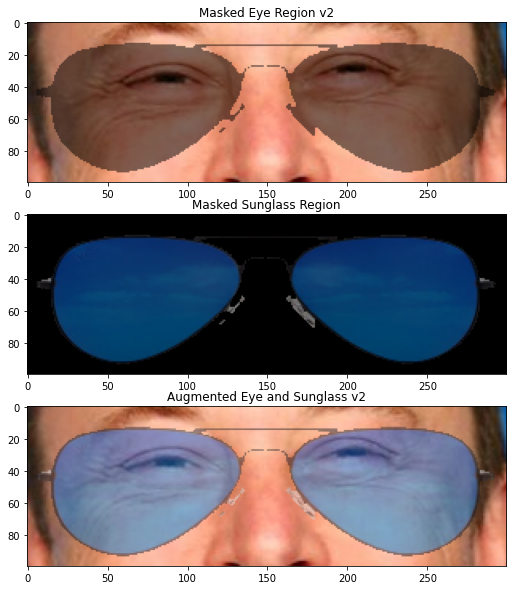

In [139]:
# Make the dimensions of the mask same as the input image.
# Since Face Image is a 3-channel image, we create a 3 channel image for the mask

FACTOR = 0.5
TRANSPARENCY = float(1-FACTOR)

glassMask = cv2.merge((glassMask1,glassMask1,glassMask1))
print(glassMask.shape)
print(glassMask[0].shape)
print('glassMask', glassMask[0][0], 'tranparent')          # tranparent pixel
print('glassMask', glassMask[40][50], 'not tranparent')    # not transparent pixel

# Make the values [0,1] since we are using arithmetic operations
glassMask = np.uint8(glassMask/255)*TRANSPARENCY                        # TRANSPARENCY MODIFICATION
print('glassMask', glassMask[0][0], 'tranparent') 
print('glassMask', glassMask[40][50], 'not tranparent') 

# Make a copy
faceWithGlassesArithmetic = faceImage.copy()

# Get the eye region from the face image
eyeROI= faceWithGlassesArithmetic[150:250,140:440]
print('eyeROI', eyeROI[0][0])
print('eyeROI', eyeROI[40][50])

# Use the mask to create the masked eye region
maskedEyev2 = cv2.multiply(eyeROI.astype(float), 1 - glassMask)          # TRANSPARENCY MODIFICATION
print('maskedEyev2', maskedEyev2[0][0])
print('maskedEyev2', maskedEyev2[40][50])
maskedEyev2 = np.uint8(maskedEyev2)                                      # TRANSPARENCY MODIFICATION
print('maskedEyev2', maskedEyev2[0][0])
print('maskedEyev2', maskedEyev2[40][50])

# Use the mask to create the masked sunglass region
# maskedGlass = cv2.multiply(glassBGR, glassMask)
maskedGlass = cv2.multiply(glassBGR.astype(float), glassMask)            # TRANSPARENCY MODIFICATION
print('glassBGR', glassBGR[0][0])
print('glassBGR', glassBGR[40][50])
maskedGlass = np.uint8(maskedGlass)                                      # TRANSPARENCY MODIFICATION
print('maskedGlass', maskedGlass[0][0])
print('maskedGlass', maskedGlass[40][50])

# Combine the Sunglass in the Eye Region to get the augmented image
eyeRoiFinalv1 = cv2.add(maskedEyev1, maskedGlass)
eyeRoiFinalv2 = cv2.add(maskedEyev2, maskedGlass)

# Display the intermediate results
plt.figure(figsize=[20,10])

plt.subplot(311);plt.imshow(maskedEyev2[...,::-1]);plt.title("Masked Eye Region v2")
plt.subplot(312);plt.imshow(maskedGlass[...,::-1]);plt.title("Masked Sunglass Region")
plt.subplot(313);plt.imshow(eyeRoiFinalv2[...,::-1]);plt.title("Augmented Eye and Sunglass v2")

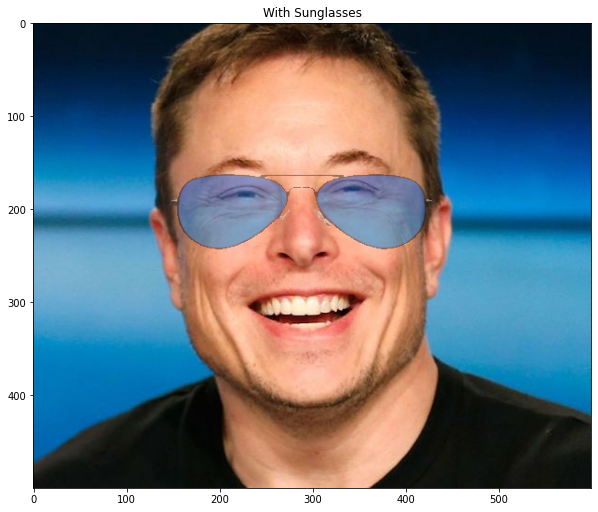

In [140]:
# Replace the eye ROI with the output from the previous section
face2 = faceWithGlassesArithmetic.copy()

face2[150:250,140:440]=eyeRoiFinalv2

# Display the final result
plt.figure(figsize=[10,10]);
plt.subplot(111);plt.imshow(face2[:,:,::-1]);plt.title("With Sunglasses");

## <font style="color:rgb(50,120,229)">Exercise</font>
Use the same logic, can you create a similar filter which can augment other objects like ear-rings, mustache etc? Try it out.

You can also try to come up with algorithms to automatically detect the region using computer vision techniques instead of checking the eye region manually.